In [2]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import random
import time

import mcpi.minecraft as minecraft
import mcpi.entity as entity
import mcpi.block as block

import mineworld.util as util
import mineworld.room as room
import mineworld.corridor as corridor

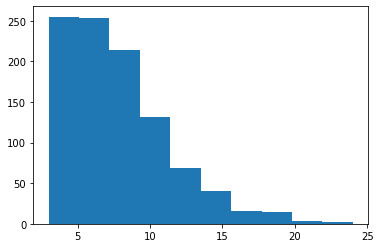

In [64]:
def inters_rv():
    return round(scipy.stats.gamma.rvs(a=3, loc=0, scale=2) + 2.0)

s = []
for i in range(0,1000):
    s.append(inters_rv())

plt.hist(s)
plt.show()

In [65]:
verbose = False

N = [0,-1]
E = [1,0]
S = [0,1]
W = [-1,0]

class Node:
    def __init__(self, x, y, is_inters=False, is_plaza=False, orig_dist=0, inters_dist=0, neigh=[], parent=None):
        self.x = x
        self.y = y
        self.is_inters = is_inters
        self.orig_dist = orig_dist
        self.inters_dist = inters_dist
        self.neigh = neigh
        self.parent = parent
        self.is_plaza = False

    def get_eligible(self):
        parent_relative = None
        if self.parent!=None:
            parent_relative = [self.parent.x - self.x, self.parent.y - self.y]

        if self.is_inters:
            eligible = [N, E, S, W]
        else:
            # Only straight - calculate node opposite parent
            eligible = [[parent_relative[0] * -1, parent_relative[1] * -1]]

        for n in self.neigh:
            neigh = [n.x - self.x, n.y - self.y]
            if neigh in eligible:
                eligible.remove(neigh)
        if parent_relative in eligible:
            eligible.remove(parent_relative)
        
        return eligible

    def coord_str(self):
        return('(%d,%d)' % (self.x, self.y))

    def __str__(self):
        return '(%d,%d,n=%d,od=%d,id=%d) <= %s' % (self.x, self.y, len(self.neigh), self.orig_dist, self.inters_dist, self.parent)

def draw_map(existing, origin=None, new=None):
    for y in range(-20,21):
        for x in range(-20,21):
            if origin!=None and origin.x==x and origin.y==y:
                    print('o', end='')
            elif new!=None and new.x==x and new.y==y:
                    print('+', end='')
            elif '(%d,%d)' % (x,y) in existing:
                n = existing['(%d,%d)' % (x,y)]
                if n.is_inters:
                    print('x', end='')
                else:
                    print('▪', end='')
            else:
                print(' ', end='')
        print('')

def generate(existing, origins, wiggle, steps, inters_rv, plaza_p, long_road_p):
    for o in origins:
        existing[o.coord_str()] = o

    for i in range(0,steps):
        if verbose:
            print("\nIteration %d" % i)
        min_od = None
        od = 0

        candidates = []
        search = origins
        while min_od==None or od<min_od+wiggle-1:
            adj = []
            od += 1
            for n in search:
                if verbose:
                    print('Visiting %s' % n)
                for a in n.neigh:
                    if verbose:
                        print('New search: %s' % a)
                    adj.append(a)
                    existing[a.coord_str()] = a

                eligible = n.get_eligible()
                for c in eligible:
                    if '(%d,%d)' % (n.x+c[0], n.y+c[1]) in existing:
                        continue

                    if min_od==None:
                        min_od = n.orig_dist+1

                    cand = Node(
                        n.x+c[0],
                        n.y+c[1],
                        orig_dist=n.orig_dist+1,
                        inters_dist=n.inters_dist+1,
                        parent=n,
                        neigh=[],
                    )

                    if verbose:
                        print('Found canditate: %s' % cand)
                    candidates.append(cand)
                
            search = adj

        if len(candidates)==0:
            if verbose:
                print('No candidates found')
            break 

        new = np.random.choice(candidates)
        if new.inters_dist>=inters_rv():
            new.is_inters = True
            if random.uniform(0.0,1.0)<plaza_p:
                # Plaza - this triggers intersections on the next tile
                new.inters_dist = 100
            else:
                new.inters_dist = 0
        else:
            if random.uniform(0.0, 1.0)<long_road_p:
                # Long road from here
                new.inters_dist = new.inters_dist-10

        if verbose:
            print('Adding node: %s' % new)
        new.parent.neigh.append(new)
        existing[new.coord_str()] = new

existing = {}
generate(existing, origins=[Node(0,0,is_inters=True,inters_dist=100)], wiggle=5, steps=500, inters_rv=inters_rv, plaza_p=0.05, long_road_p=0.05)
draw_map(existing)


            ▪▪▪x▪▪▪▪x▪▪▪▪x▪▪▪            
               ▪    ▪    ▪    ▪          
               ▪    ▪x▪▪▪x▪▪▪ ▪          
               ▪    ▪    ▪    ▪          
            ▪▪▪▪▪▪▪▪x▪▪▪▪▪    ▪          
                ▪▪  ▪    ▪    ▪          
                ▪x▪▪▪    ▪    ▪          
        ▪       ▪▪  ▪▪▪▪▪x▪▪▪▪x▪▪▪▪▪     
        ▪       ▪▪  ▪    ▪  ▪ ▪    ▪     
        ▪       ▪▪  ▪    ▪  ▪ ▪    ▪     
        ▪       ▪▪▪▪x▪▪▪▪▪▪▪x▪▪    ▪     
        ▪       ▪▪  ▪    ▪  ▪▪x▪▪▪▪x▪▪x  
  ▪▪▪▪▪▪x▪▪▪    ▪x▪▪▪    ▪  ▪ ▪    ▪ ▪   
      ▪ ▪       ▪▪  ▪    ▪  ▪ ▪    ▪ ▪   
      ▪ ▪      ▪▪▪  ▪    ▪  ▪ ▪      ▪   
      ▪ ▪    ▪▪x▪▪▪▪x▪▪▪▪x▪▪x▪▪      ▪   
      ▪ ▪      ▪▪▪  ▪    ▪ ▪▪ ▪      ▪   
      ▪ ▪      ▪▪▪  ▪    ▪ ▪▪ ▪      ▪   
▪▪▪▪▪▪x▪x▪▪▪▪▪▪x▪▪  ▪    ▪ ▪▪ ▪      ▪   
      ▪ ▪      ▪▪x▪▪x▪▪▪▪▪▪x▪▪x▪▪▪▪▪▪x▪▪▪
      ▪ ▪      ▪▪▪▪xxx▪▪▪▪▪▪  ▪      ▪   
▪▪▪▪▪▪▪▪x▪▪▪▪▪▪▪x▪▪▪x▪▪▪▪▪▪x▪▪▪      ▪   
        ▪    ▪  ▪   ▪      ▪  ▪      ▪▪  
        ▪    ▪  ▪   ▪      ▪  ▪   

In [28]:
mc = minecraft.Minecraft.create(address='127.0.0.1')

In [58]:
print(mc.player.getPos())

print('Cleaning up')
mc.setBlocks(-20*util.TILE_SIZE, -10, -20*util.TILE_SIZE, 20*util.TILE_SIZE, 20, 20*util.TILE_SIZE, block.AIR) 
time.sleep(30)
mc.setBlocks(-20*util.TILE_SIZE, -10, -20*util.TILE_SIZE, 20*util.TILE_SIZE, 20, 20*util.TILE_SIZE, block.STONE) 
print('Done cleaning')
time.sleep(30)

Vec3(-27.983421570138034,1.0,2.784875734273669)
Cleaning up
Done cleaning


In [59]:
hole_map = {
    '(%d,%d)' % (N[0], N[1]): util.NORTH,
    '(%d,%d)' % (E[0], E[1]): util.EAST,
    '(%d,%d)' % (S[0], S[1]): util.SOUTH,
    '(%d,%d)' % (W[0], W[1]): util.WEST,
}

playerMoved = False
print('Drawing...')
for ek in existing:
    e = existing[ek]
    holes = []
    for dir in [N,E,S,W]:
        if '(%d,%d)' % (e.x+dir[0], e.y+dir[1]) in existing:
            holes.append(hole_map['(%d,%d)' % (dir[0], dir[1])])
    
    corridor.draw_corridor(mc, *util.to_world(e.x, 0, e.y), holes=holes)
    if not playerMoved:
        playerMoved = True
        pp = util.to_world(e.x, 0, e.y)
        mc.player.setPos(pp[0]+5, pp[1]+1, pp[2]+5)

print('Finished!')

DrawingFinished!
